---

## Detection and Tracking with YOLO and Kalman Filter using C4dynamics

This notebook runs an example of detecting vehicles in images using YOLO, and then tracking those detected cars using a Kalman filter.  

The example is based on the project of *Amit Elbaz* which can be found here - https://github.com/elbazam/multi_object_tracking/tree/main


The implementation is based on the C4dynamics algorithms engineering framework, which provides a robust and efficient environment for developing and testing advanced computer vision and other physcial systems algorithms.

### Installation

Make sure to have the following prerequisites:

1. Python 3 installed.
2. Jupyter Notebook installed.
3. Numpy, Tensorflow, Scikit-Learn, OpenCV, Matplotlib installed.
4. C4dynamics framework installed. You can download from:

https://github.com/C4dynamics/C4dynamics

### Dataset

For this demonstration, we will be using a dataset of traffic surveillance videos. The dataset contains video sequences recorded from a traffic camera, capturing various vehicles including cars.

### Car Detection with YOLO

Starting by implementing a real-time, high accuracy cars detection using YOLO. 
We will leverage the pre-trained YOLO model available in the C4dynamics framework.

In this section, we will:

1. Load and preprocess the dataset.
2. Initialize the YOLO model.
3. Perform car detection on sample images.
4. Visualize the detected cars.

### Car Tracking with Kalman Filter

After detecting the cars in the images, we will track them over time using a Kalman filter. The Kalman filter is a recursive algorithm that estimates the state of a dynamic system given noisy measurements. By integrating the Kalman filter with our car detection results, we can track the movement of cars and predict their future positions.

In this section, we will:

1. Initialize the Kalman filter.
2. Extract the detected car positions.
3. Update the Kalman filter with the detected car positions.
4. Predict and visualize the tracked car positions.

### Summary

By combining car detection using YOLO and car tracking with the Kalman filter, we can achieve robust and accurate tracking of cars in surveillance videos.  
The C4dynamics algorithms engineering framework provides an efficient environment for implementing and evaluating such computer vision algorithms. In this example, leveraging *Amit Elbaz* masters' project to detect and track vehicles with Yolo and Kalman Filter. 

Let's start!

In [15]:
# load c4dynamics
## 
exec(open('importc4d.py').read())

tic()
#
# https://github.com/elbazam/multi_object_tracking
##
import numpy as np
import cv2
from sklearn.neighbors import NearestNeighbors
# %matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from enum import Enum
# import pandas as pd 

#
# config pyplot
##
import matplotlib.ticker as ticker

plt.rcParams["font.family"] = 'Times New Roman' # "Britannic Bold" # "Modern Love"#  "Corbel Bold"# 
plt.rcParams["font.size"]   = 20
# plt.rcParams["font.weight"] = 'bold'

plt.style.use('dark_background')  

plt.rcParams['figure.figsize'] = (9.0, 6.0) 
plt.rcParams['image.interpolation'] = 'nearest'
# plt.ion()



# User Input

In [16]:
# user input
##
videoname    = 'tank_short' # 'b1b_rok_japan'  #'usmc_xq_58a' # 'carrier_truman' #    'cars1'  #'tank_race' #   'cars2' #   'F-16_Takeoff'    #   
detectortype = 'opencv' #  'tf'  #  

t_start      = 0 # 30
tf           = 1 # 0.001  #   2 #   .08 #     
    
#    
# initial settings 
##
outfol = os.path.join('examples', 'out', detectortype)
if not os.path.exists(outfol):
    os.makedirs(outfol)

videoin  = os.path.join('examples', 'resources', videoname + '.mp4')
videoout = os.path.join(outfol, videoname + '.mp4')    

# Video Preprocessing 

In [17]:
def openvideo():
    cvideo       = cv2.VideoCapture(videoin)
    dt          = 1 / cvideo.get(cv2.CAP_PROP_FPS) # 1 / frame per second = the length of a single frame
    Nframes     = int(cvideo.get(cv2.CAP_PROP_FRAME_COUNT)) # total frames count 
    tf_video    = Nframes * dt 

    fwidth  = int(cvideo.get(cv2.CAP_PROP_FRAME_WIDTH))
    fheight = int(cvideo.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_out  = cv2.VideoWriter(videoout, cv2.VideoWriter_fourcc(*'mp4v')
                    , int(cvideo.get(cv2.CAP_PROP_FPS)), [fwidth, fheight])

    return cvideo, video_out, tf_video, fwidth, fheight, dt

cvideo, cvideo_out, tf_video, fwidth, fheight, dt = openvideo()

# Load a Detector 

In [18]:
yolodet = c4d.detectors.yolo()

# Define Kalman Parameters

In [19]:
# x(t) = A(t) * x(t-1) + e(t) || e(t) ~ N(0,Q(t))
# z(t) = H(t) * x(t) + r(t)   || r(t) ~ N(0,R(t))

# x(t) = [x1 y1 x2 y2 vx vy]

A = np.array([[1, 0, 0, 0, dt, 0 ]
            , [0, 1, 0, 0, 0,  dt]
            , [0, 0, 1, 0, dt, 0 ]
            , [0, 0, 0, 1, 0,  dt]
            , [0, 0, 0, 0, 1,  0 ]
            , [0, 0, 0, 0, 0,  1 ]])

H = np.array([[1, 0, 0, 0, 0, 0]
            , [0, 1, 0, 0, 0, 0]
            , [0, 0, 1, 0, 0, 0]
            , [0, 0, 0, 1, 0, 0]])

P = np.eye(A.shape[1])

Q = np.array([[25, 0,  0,  0,  0,  0]
            , [0,  25, 0,  0,  0,  0]
            , [0,  0,  25, 0,  0,  0]
            , [0,  0,  0,  25, 0,  0]
            , [0,  0,  0,  0,  49, 0]
            , [0,  0,  0,  0,  0,  49]])

R = dt * np.eye(4)


# Tracker = Data Point + Kalman Filter
### (Data point and Kalman filter are core elements of C4dynamics)

In [20]:
class trkstate(Enum):
    CLOSED      = 0
    PREDICTED   = 1
    CORRECTED   = 2


    
class tracker(c4d.datapoint):
    ''' 
        TODO 
        1) a tracker object is actually a 2 datapoints object
        2) reconsider the kalman filter. it is maybe not required for eqch tracker to hold one.
            but the kalman holds the state (why if it is hold ny the dp?)

        3) other option the object is a single dp with height & width att's.
        4) then the measure as kalman update should be changed to a center only and the matrices be modified as well.
    '''
    
    # a datapoint 
    # kalman filter 
    # display color
    ## 
    
    def __init__(obj, z): # , measure_id, t):

        super().__init__()  # Call the constructor of c4d.datapoint
         
        # initialize the state with direct substitution of the meausre 
        obj.filter = c4d.filters.kalman(np.hstack((z, np.zeros(2))), P, A, H, Q, R)
        
        obj.state = trkstate.PREDICTED
        obj.appear = 0
        obj.counterSame = 0
        obj.counterEscaped = 0

        obj.color = np.random.randint(0, 255, size = 3).tolist()

        # obj.measure_id = -1 # [t, measure_id



    def isvalid(obj, measure):
        # 
        # confirm valid measure for state correction 
        ## 

        if len(measure) == 0:
            return False  
        elif obj.appear < 8:
            return True
        
        #
        # otherwise, innovation test
        #   assess whether a new measurement is consistent with the filter's state estimate
        ## 

        # difference between the actual measurement (measure) and the predicted measurement
        innovation = measure - np.dot(obj.filter.H, obj.filter.x)
        # innovation covariance matrix (propagates the error covariance matrix P through the measurement matrix H + noise covariance matrix R)
        S = np.dot(obj.filter.H, np.dot(obj.filter.P, obj.filter.H.T)) + obj.filter.R
        # Mahalanobis distance squared (epsilon). 
        #   quantify how many standard deviations the innovation is away from the expected value 
        #   based on the covariance matrix S. 
        # use the inverse of S to normalize the innovation vector and make it comparable.
        epsilon = np.dot(innovation.T, np.dot(np.linalg.inv(S), innovation))

        return epsilon < 9.488 # chi
        
        


    
    def position(obj):
        # kalman states:
        #   x(t) = [x1 y1 x2 y2 vx vy]
        # then x[:4] are the center coords.
        ##
        return np.array(obj.filter.x[:4].astype(np.int32))


    def getvelocity(obj):
        # kalman states:
        #   x(t) = [x1 y1 x2 y2 vx vy]
        # then x[4:] are the velocity coords.
        ## 
        return obj.filter.x[4:].astype(np.int32)


    def getcenter(obj):
        center = np.zeros(2)
        state = obj.position()
        center[0] = 0.5 * (state[0] + state[2])
        center[1] = 0.5 * (state[1] + state[3])
        return center.astype(np.int32)



    def duplicated(obj):
        obj.counterSame += 1
        if obj.counterSame > 3:
            return True
        return False
    


    def advance(obj, corrected):

        if corrected:
            obj.counterEscaped = 0
            obj.appear += 1
            obj.state = trkstate.CORRECTED
        else:
            obj.counterEscaped += 1

            if obj.counterEscaped > 40:
                obj.state = trkstate.CLOSED
            else:
                obj.state = trkstate.PREDICTED

            
    
    
    def __eq__(obj, other):
        x1 = obj.position()
        x2 = other.position()
        if np.linalg.norm(x1 - x2) < 10: 
            return True 

# Trackers Manager

### (a dictionary of trackers and methods to add and remove elements)

In [21]:
# trackers manager:
#   list of active trackers
#   add or remove tracks methods
class mTracks:
    #
    # this class shouldnt belong to this project notebook but to the body module of c4d.
    # theres also should be a saperation between the objects detecton processing and the objects bank handling. 
    # however this class cannot currently be introduced as is to c4dyanmics as it doesnt handle body objects but handles tracks
    # which is another class of this nb. 
    ## 
    
    def __init__(obj):
        obj.trackers = {}
        # obj.removelist = []
        obj.neigh = NearestNeighbors(n_neighbors = 1)
        # threshold of 100 pixels to verify the measure is close enough to the object. 
        obj.thresh = 100 

        #
        # for debug only
        ##
        obj.measurecnt = 0
        obj.zdList = np.empty((0, 6))
        # obj.trk_df = pd.DataFrame(columns = ['R1', 'R2', 'R3'])

        obj.cov = 25 * np.eye(4) 


    def add(obj, key, z):#, measure_id):
        obj.trackers[key] = tracker(z)
    

    def trackerMaker(obj, zList, t):
        # 
        # updates the existing trackers based on a list of new observations zList. 
        # uses the Nearest Neighbors algorithm to find the nearest observation for each tracker, 
        # associates them, and then creates new trackers for any unassociated observations.
        ## 
        RestOfZ = np.copy(zList)

        check = NearestNeighbors(n_neighbors = 1)
        # fits the nearest neighbors model (check) with the data in zList. 
        #   prepares the model for nearest neighbor searches in the zList. 
        check.fit(zList)

        AssociatedZ = [] # an empty list to store associated data points.
        delist      = []
        
        for trk in obj.trackers.values():
            
            _, idx = check.kneighbors([trk.position()]) # uses the previously created nearest neighbors model to find the index of the nearest neighbor to the kfPose in the zList
            
            if idx[0][0] not in delist:
                # If the found index of the nearest data point is not already in the delist, 
                #   (the data point hasn't been associated with any other tracker), 
                #   it is considered an association with the current object tracker. 
                #   This data point is then appended to the AssociatedZ list.
                ## 
                AssociatedZ.append(zList[idx[0][0]])
                delist.append(idx[0][0])
                
                

        # AssociatedZ contains the data points from zList that are currently associated 
        #   with the object trackers in the loop. 
        # This list will be used for further processing or analysis related to the object tracking system.
        AssociatedZ = np.array(AssociatedZ)


        RestOfZ = np.delete(RestOfZ, delist, 0)
        
        if list(obj.trackers.keys()):
            # If there are keys in obj.trackers, calculate the next available key for a new tracker, 
            #   ensuring there are no duplicates.
            lastKey = list(obj.trackers.keys())[-1] + 1
            while lastKey in list(obj.trackers.keys()):
                lastKey += 1
        else:
            lastKey = 0
            
        RestOfZSize = AssociatedZ.shape[0] # calculate the size of the remaining data points in AssociatedZ and store it.
        
        if RestOfZSize > 0 and not lastKey == 0:
            # If there are data points in RestOfZ and the last key is not 0, 
            #   fit the nearest neighbors model 'check' with the AssociatedZ.
            check.fit(AssociatedZ)
            
        UpdateTracker = True
        n = zList.shape[1]
        
        
        for z in RestOfZ:
            # iterate over the remaining data points in RestOfZ.
            if not lastKey == 0 and RestOfZSize > 0:
                
                UpdateTracker = False
                _, idx = check.kneighbors([z])
                v = z - AssociatedZ[idx[0][0]]
                epsilon = np.dot(v.T, np.dot(np.linalg.inv(obj.cov), v))
                # set the UpdateTracker based on certain conditions involving the Kalman Filter's error.
                if (n == 2 and not epsilon < 5.991) or (n == 4 and not epsilon < 9.448): 
                    UpdateTracker = True
                # elif n == 4 and not epsilon < 9.448: 
                #     UpdateTracker = True
            
            if UpdateTracker:
                print(f'{t:.2f}s: new track: {lastKey}')
                obj.add(lastKey, z)# , measure_id) #1 track creation 
                lastKey += 1
                UpdateTracker = False

        
    def refresh(obj, zList, frame, t, zarray, outfile):
        # updates the state of each tracker:
        #   - Performs measurements handling. \\ isnt the meausre performed in the main? \\ 
        #   - Associates trk id by a nearest neighbor.
        #   - Visualizes the tracked objects on the frame.
        ## 
        for key, trk in obj.trackers.items():
            if trk.state == trkstate.CLOSED:
                continue
            #
            # three options for the trk state in the end of this procedure:
            #   CORRECTED:      if conditions for correct are satisfied
            #   PREDICTED:      if conditions for correct are'nt satisfied
            #   CLOSED:         if counterEscaped exceed threshold 
            ##

            # 
            # predict
            # reason to do prediction always before the correct stage:
            #   1) the measure doesnt update all the variables in the state 
            #   2) the correct is based on the previous state and only makes a correction to it by:
            #       x = x + K @ y
            #      the same is true also for the covariance matrix. 
            #   3) it fill the gaps when the measurement is not valid for correcting the state. 
            ##
            obj.trackers[key].filter.predict()


            # 
            # prepare for the correct stage 
            ##

            measurement = []

            if zList.shape[0] == 1: # one row
            # if zarray.shape[0] == 1: 
                #
                # if exactly one measure exists, no need to check which is closest 
                # how it knows that it belongs to this track? 
                ##
                measurement = zList[0]
                # measurement = zarray[:4, ]
                # measure_id = zarray[4]

            elif zList.shape[0] >= 2:
                #
                # if more than one measure, check which is the closest. 
                # 
                # what's the vlaue of doing predict in a phase of correct? perhaps it was there to predict the next posoition for comparison with the input measures. 
                ##

                # 
                # d: Distances Array 
                #   This array contains the distances between each sample and its k-nearest neighbors.
                #   Each row corresponds to a sample, and the values in that row represent the distances to its 
                #   k-nearest neighbors.
                # 
                # relativeIndex: Indices Array
                #   This array contains the indices of the k-nearest neighbors for each sample. 
                #   Each row in the array corresponds to a sample in the dataset, and the values 
                #   in that row represent the indices of its k-nearest neighbors in the dataset.
                ##  
                d, relativeIndex = obj.neigh.kneighbors(obj.trackers[key].position()[np.newaxis, :])
                
                # as we query one element with 1 neighbor it's possible to extract the results with item():
                if d.item() < obj.thresh:
                    # pretty close 

                    
                    z = zList[relativeIndex.flatten()] # np.array()
                    # z = zarray[relativeIndex[0], :4] 
                    # measure_id = zarray[relativeIndex.item(), 4]

                    if len(z) == 1: # # i dont understand how kneighbors() can return more than 1 if we alwasy introduce one track's position. 
                        measurement = z[0]
                    else:
                        npDistances = d.flatten() # reduce a single order. 
                        npDistances = npDistances * npDistances
                        weights = 1 - npDistances / np.sum(npDistances)
                        # return np.average(z, weights = weights, axis = 0)
                        measurement = np.average(z, weights = weights, axis = 0)
                    




            corrected = obj.trackers[key].isvalid(measurement)


            # if len(measurement) == 0:
            #     corrected = False 
            # else:
            #     innovation = measurement - np.dot(obj.trackers[key].filter.H, obj.trackers[key].filter.x)
            #     S = np.dot(obj.trackers[key].filter.H, np.dot(obj.trackers[key].filter.P, obj.trackers[key].filter.H.T)) + obj.trackers[key].filter.R
            #     epsilon = np.dot(innovation.T, np.dot(np.linalg.inv(S), innovation))

            #     if obj.trackers[key].appear < 8:
            #         corrected = True
            #     else: 
            #         corrected = epsilon < 9.488 
                


            # if outfile is not None: 
            #     if t < 0.05: # ne frame 
            #         with open(outfile, 'at') as file:
            #             file.write(f'{t:.2f} \t {np.array2string(measurement, precision = 0)} \n')


            if corrected:
                # 
                # correct 
                ##
                obj.trackers[key].filter.correct(measurement)
                # obj.trakcers[key].measure_id = TBD


            #
            # record trk state, 
            # quit if closed
            ## 
            obj.trackers[key].advance(corrected) 
            if obj.trackers[key].state == trkstate.CLOSED:
                print(f'{t:.2f}s: closing trk {key}')
                continue


            #
            # prepare to present on the frame
            ##

            pose = obj.trackers[key].position()
            vel = obj.trackers[key].getvelocity() * dt
            center = obj.trackers[key].getcenter()
            color = trk.color
            
            obj.trackers[key].x = center[0]
            obj.trackers[key].y = center[1]
            obj.trackers[key].vx = vel[0]
            obj.trackers[key].vy = vel[1]
            

            obj.trackers[key].store(t)
            obj.trackers[key].storevar('state', t)
            # obj.trackers[key].storevar('measure_id', t)

            # if obj.trackers[key].state == trkstate.CORRECTED: 
            cv2.rectangle(frame, (pose[0], pose[1]), (pose[2], pose[3]), color, 2)
            cv2.putText(frame, 'id: ' + str(key), (center + [0, -10]), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
            cv2.arrowedLine(frame, center, center + vel.astype(np.int32), color, 4)
                
    
    def RemoveDoubles(obj, t):
        # more trackers than measurements
        # removes duplicate trackers that are close to each other. 
        # compares trackers and removes duplicates based on a threshold.
        ##

        # keys = list(obj.trackers.keys())
        keys = [key for key, value in obj.trackers.items() if not value.state == trkstate.CLOSED]

        KeysVisited = []
        
        for key in keys:
            for inKey in keys:
                if key == inKey or inKey in KeysVisited:
                    continue
                if obj.trackers[key] == obj.trackers[inKey]:

                    

                    if obj.trackers[inKey].duplicated():
                        obj.trackers[inKey].state = trkstate.CLOSED
                        print('{t:.2f}: closing duplicated trk ' + str(inKey))


            KeysVisited.append(key)
            
        # for inKey in KeysRemove:
        #     print("Removing doubles")
        #     print(f'deleted existing data with key: {inKey}')
        #     try: 
        #         obj.trackers.pop(inKey)
        #     except: 
        #         print('deleted this key before')


# Main Loop

In [22]:
def run(tf = tf_video, showmustgoon = True, outfile = None):

    with open(outfile, 'wt') as file:
        file.write(f'')

    mtracks = mTracks()
    
    
    t = 0
    
    while cvideo.isOpened():
        
        ret, frame = cvideo.read()
        # frame = frame.astype(np.uint8)
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Assuming input frames are in BGR format
        
        if not ret: 
            break


        
        #
        # the update function runs the main trackers loop.  
        #
        # retrieves object measurements from the current frame using the object detector (YoloDetector).
        # 
        # the output result is two coordinates for x (left [column 0], and right [column 2]) 
        #   of the bounding box, and two coordinates for y (top [column 1], and bottom (column [3]))
        ##
        zList, z_classes = yolodet.measure(frame, t, outfile) 

        zarray = np.concatenate((zList.reshape(-1, 4)
                                , np.arange(mtracks.measurecnt, mtracks.measurecnt + zList.shape[0])[:, np.newaxis]
                                , np.ones((zList.shape[0], 1)) * t)
                                        , axis = 1)
        mtracks.zdList = np.concatenate((mtracks.zdList, zarray), axis = 0)
        mtracks.measurecnt += zList.shape[0]

        # for z in zList: 
        #     mtracks.zdList[mtracks.measurecnt] = (t, z)
        #     mtracks.measurecnt += 1
        

        # updates the trackers dictionary by adding or removing tracks.  
        # creates new trackers if there are more 
        # measurements than trackers and removes duplicate trackers if 
        # there are more trackers than measurements.
        #
        # TODO 
        # this one should check status not validity: 
        # np.sum([trk.state != trkstate.CLOSED for trk in mtracks.trackers.values()])
        # !
        kfNumber = len(mtracks.trackers.keys())
        zNumber = zList.shape[0]
        
        if kfNumber < zNumber:
            # more measurements than trackers
            mtracks.trackerMaker(zList, t)
            
        elif kfNumber > zNumber and zNumber > 0:
            # more trackers than measurements
            mtracks.RemoveDoubles(t)
        
        
        # fits the Nearest Neighbors algorithm to the object 
        # measurements for association purposes.
        if zList.shape[0] >= 2:
            mtracks.neigh.fit(zList)


        mtracks.refresh(zList, frame, t, None, outfile)
        print(z_classes)
        



        #
        # debug
        ##

        # if t > 0.66 and t <= 0.8:
        #     fol, _ = os.path.split(outfile)
        #     cv2.imwrite(os.path.join(fol, str(round(t, 4)).replace('.', '_') + '.png'), frame)

        # if outfile is not None: 
        #     if t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             file.write(f'zlist: {len(zList)} \n\n')

        # save the list of raw measures with id and timestamp
        # save the list of trackers with timestamp and associated id. 




        # mtracks.remove()

        if showmustgoon:
            cv2.imshow('image', frame)
            
        cvideo_out.write(frame)


        save_frames = True
        if save_frames == True:
            cv2.imwrite(os.path.join(outfol, str(t).replace('.', '_') + '.png'), frame)

        t += dt
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or t > tf:
            break
        
        
    cv2.destroyAllWindows()
    cvideo_out.release()
    return mtracks



# Run

In [23]:
tic()

if not cvideo_out.isOpened():
    cvideo, cvideo_out, tf_video, fwidth, fheight, dt = openvideo()

# Tvideo = Nframes * t_start -> Nframes = Tvideo / dt
Nframes = t_start / dt
cvideo.set(cv2.CAP_PROP_POS_FRAMES, Nframes)



ltrk = run(tf = tf, showmustgoon =  False, outfile = os.path.join(outfol, 'debug_' + videoname + '.txt'))

#
# 32/32 [==============================] - 0s 2ms/step
#
# 32/32                                 current batch number
# [==============================]      progress bar
# 0s                                    time elapsed for processing the current batch. 
# 2ms/step                              time taken to process each step (each batch) in milliseconds. 

print('video length: ' + str(tf) + '\n'
        + 'number of detected objects: ' + str(len(ltrk.trackers)) + '\n'
            + 'process time:' + str(round(toc() / 60, 2)) + 'min')
    





0.00s: new track: 0
['truck', 'person']
0.03s: new track: 1
['truck', 'person']
['truck', 'person']


# Results Analysis

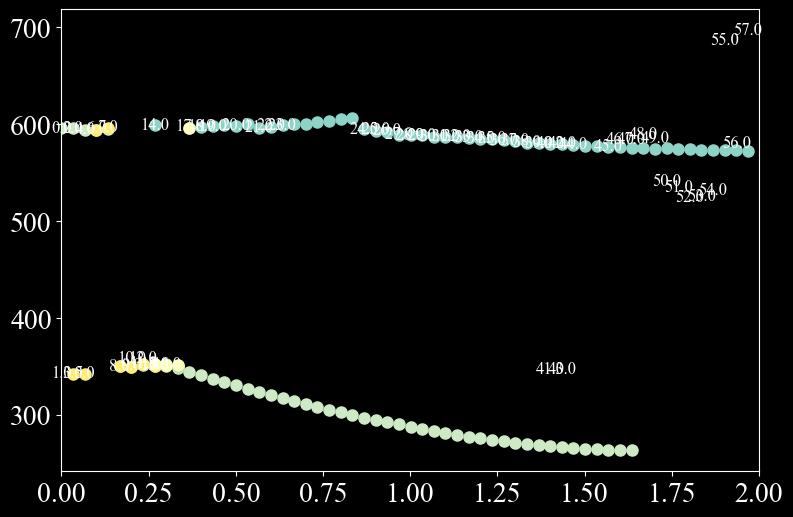

In [ ]:
# compare measures to tracks

# for each item in the tracks list, 
#   extract all the meausres associated with it and show them in different colors. 

# generate a dictionary of colors wrt the keys number 
cmap = {}
for m in range(ltrk.measurecnt):
    cmap[m] = np.random.rand(1, 3)

# for zl in ltrk.zdList:
#     print(zl)

fig = plt.figure
ax = plt.subplot(111)

for z in ltrk.zdList:
    # show r of all the detections, 
    # print(z[1])
    measure_id = z[4]
    t = z[5]
    x = 0.5 * (z[0] + z[2])
    y = 0.5 * (z[1] + z[3])
    r = np.sqrt(x**2 + y**2)

    ax.plot(t, r, marker = 'o', markersize = 0) # , color = cmap[z[1]], markersize = 8, linewidth = 0) 
    # print(f't = {t}, measure id = {measure_id}, r = {r}')
    plt.text(t, r, f'{measure_id}', fontsize = 12, ha = 'center', va = 'center')


for k, v in ltrk.trackers.items():

    t = v.get_data('t')
    # m = v.get_data('measure_id')
    r = np.sqrt(v.get_data('x')**2 + v.get_data('y')**2)

    ax.plot(t, r, marker = 'o', markersize = 8, linewidth = 0) # , color = cmap[z[1]]

    # print(f't = {t}, measure id = {measure_id}, r = {r}')
    # plt.text(t, r, f'{m}', fontsize = 12, ha = 'center', va = 'center')

    # ax.plot(t, k * np.ones_like(v.get_data('t')), linewidth = 1)
    # ax.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 

    # ax.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))


    # line = ax1.plot(t, k * np.ones_like(v.get_data('t')), linewidth = 1)
    # ax1.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 
    # ax1.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))

ax.set_xlim(0, tf)


# plt.legend(title = 'trk')
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.7, box.height])
# ax1.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
# ax1.set(xlabel = 'time (sec)',ylabel = '#trk')
# ax1.set_title('Track Number vs Life Time', fontweight = 'bold')
# ax1.grid(alpha = 0.5, axis = 'x')

# plt.show()
# plt.show(block = False)
plt.savefig(os.path.join(outfol, 'detections.jpg'))


(0.0, 2.0)

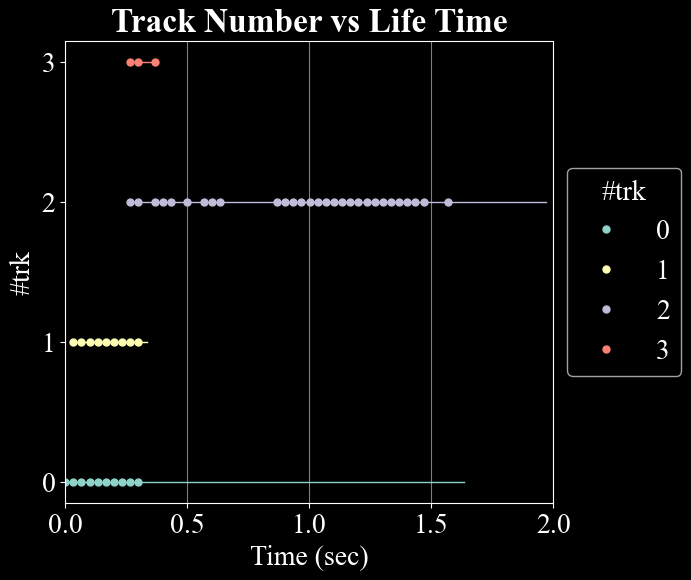

In [ ]:
# trks lifetime 

fig1 = plt.figure(1)
ax1  = plt.subplot(111)



for k, v in ltrk.trackers.items():
    vstate = np.vectorize(lambda x: x.value)(v.get_data('state')[:, 1])
    iscorrect = np.where(vstate == trkstate.CORRECTED.value)[0]

    line = ax1.plot(v.get_data('t'), k * np.ones_like(v.get_data('t')), linewidth = 1)
    ax1.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))




plt.legend(title = 'trk')
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.7, box.height])
ax1.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax1.set(xlabel = 'Time (sec)',ylabel = '#trk')
ax1.set_title('Track Number vs Life Time', fontweight = 'bold')
ax1.grid(alpha = 0.5, axis = 'x')

ax1.set_xlim(0, tf)



Text(0.5, 1.0, 'Tracks Range')

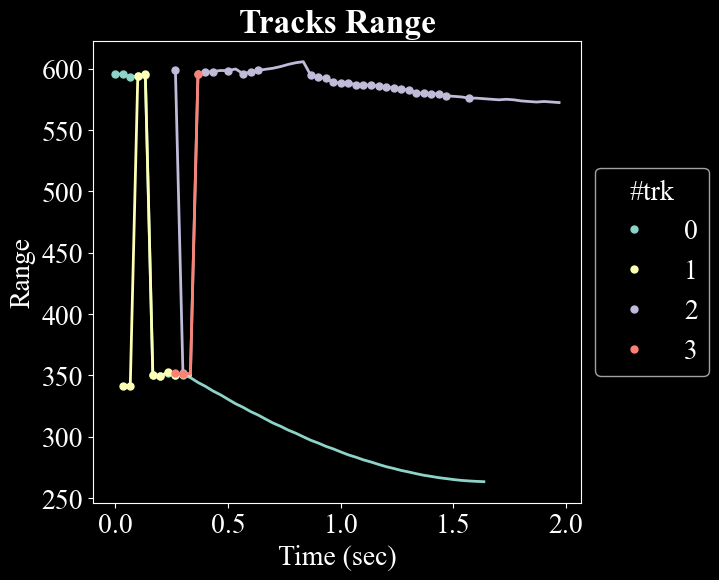

In [ ]:
# false positive
# plot range vs time and diff them below thrshold 
##


fig = plt.figure
ax = plt.subplot(111)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))

for k, v in ltrk.trackers.items():

    t = v.get_data('t')
    r = np.sqrt(v.get_data('x')**2 + v.get_data('y')**2)

    vstate = np.vectorize(lambda x: x.value)(v.get_data('state')[:, 1])
    iscorrect = np.where(vstate == trkstate.CORRECTED.value)[0]

    line = ax.plot(t, r, linewidth = 2)
    ax.plot(v.get_data('t')[iscorrect], r[iscorrect], marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 


plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'Time (sec)',ylabel = 'Range')
ax.set_title('Tracks Range', fontweight = 'bold')
# ax.grid(alpha = 0.5, axis = 'x')

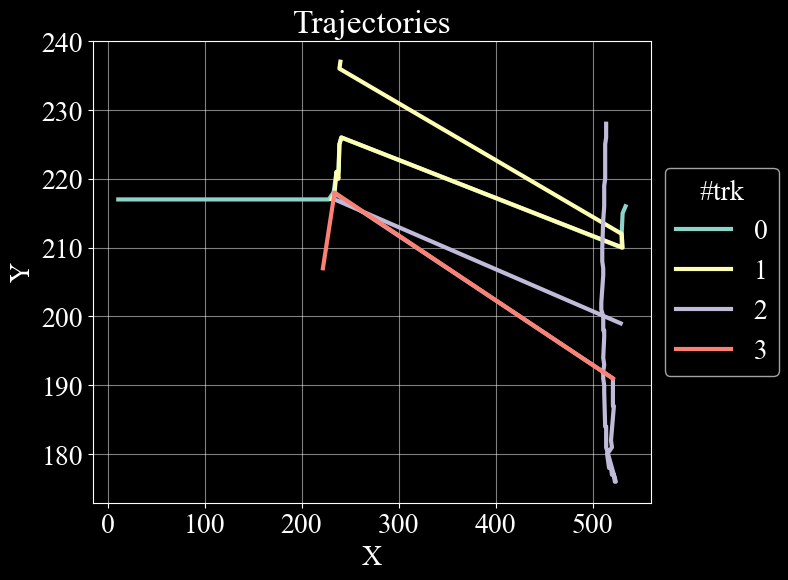

In [ ]:
# trajectories

fig = plt.figure
ax = plt.subplot(111)

for k, v in ltrk.trackers.items():
    ax.plot(v.get_data('x'), fheight - v.get_data('y'), linewidth = 3, label = str(k))

plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'X',ylabel = 'Y')
ax.set_title('Trajectories')
ax.grid(alpha = 0.5)
plt.show() 

